In [1]:
# EDA

from pymongo import MongoClient # import mongo client to connect
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, isnan, mean, stddev, min, max, desc
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, FloatType
import urllib.parse
from sklearn.preprocessing import MinMaxScaler

In [2]:
username = "alextran21211"
password = urllib.parse.quote("database12345")
host = "cluster0.zsych.mongodb.net"
url = "mongodb+srv://{}:{}@{}/?retryWrites=true&w=majority".format(username,
password, host)
# connect to the database
client = MongoClient(url)

In [3]:
db = client['group_5_project']
collection = db["co2_emission"]

documents = collection.find()

data = []

for doc in documents:
    for country, country_data in doc.items():
        if country == "_id":
            continue  
        iso_code = country_data.get('iso_code')
        for entry in country_data.get('data', []):
            year = entry.get('year')
            population = entry.get('population')
            co2 = entry.get('cumulative_luc_co2')
           
            data.append({
                'Country': country,
                'ISO_Code': iso_code,
                'Year': year,
                'Population': population,
                'CO2': co2
            })


df = pd.DataFrame(data)


In [4]:
print(df.isnull().sum()) 

Country           0
ISO_Code       7867
Year              0
Population     8001
CO2           10393
dtype: int64


In [5]:
df['Population'] = df['Population'].fillna(df['Population'].mean()) 
df['CO2'] = df['CO2'].fillna(df['CO2'].mean())  
df['ISO_Code'] = df['ISO_Code'].dropna

In [6]:
df['CO2_per_capita'] = df['CO2'] / df['Population']

In [7]:
df.drop_duplicates(inplace=True)

In [8]:
df = df.drop(columns=['ISO_Code'])
print(df.head())

       Country  Year  Population        CO2  CO2_per_capita
0  Afghanistan  1850   3752993.0   2.979601    7.939267e-07
1  Afghanistan  1851   3767956.0   5.981443    1.587450e-06
2  Afghanistan  1852   3783940.0   9.002998    2.379266e-06
3  Afghanistan  1853   3800954.0  12.041333    3.167977e-06
4  Afghanistan  1854   3818038.0  15.094068    3.953357e-06


In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for Seaborn plots
sns.set(style="whitegrid")


1. Trend in CO₂ Emissions Over Time

c:\Users\tranh\anaconda3\envs\adsc3910-project-group-5\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


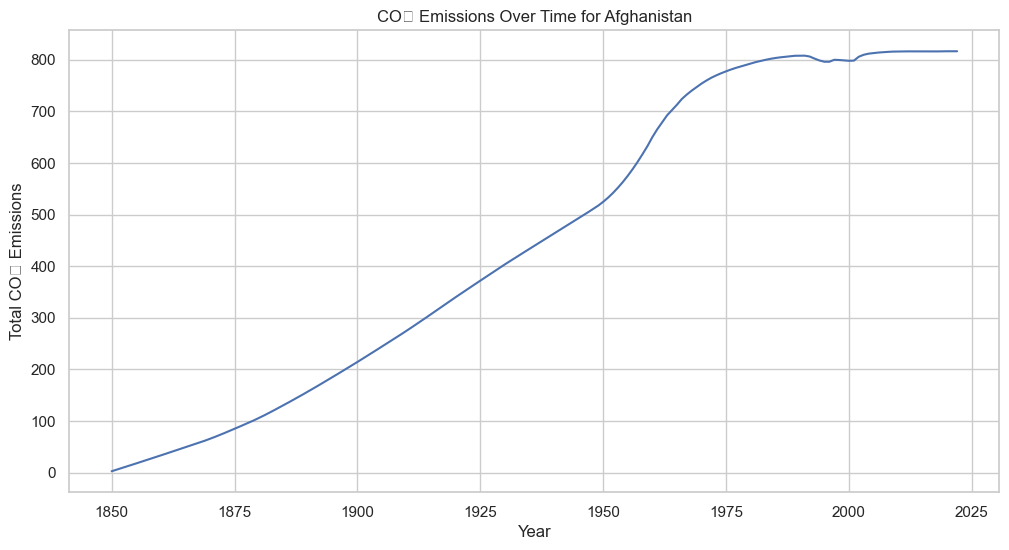

In [14]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=df[df['Country'] == "Afghanistan"], x='Year', y='CO2', color="b")
plt.title("CO₂ Emissions Over Time for Afghanistan")
plt.xlabel("Year")
plt.ylabel("Total CO₂ Emissions")
plt.show()


2. CO₂ Emissions Per Capita Over Time

c:\Users\tranh\anaconda3\envs\adsc3910-project-group-5\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


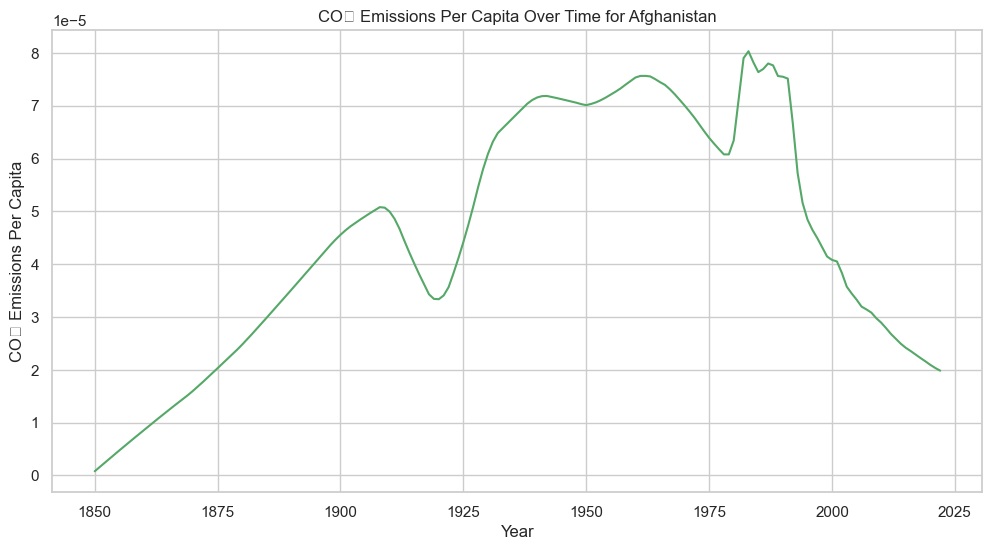

In [15]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=df[df['Country'] == "Afghanistan"], x='Year', y='CO2_per_capita', color="g")
plt.title("CO₂ Emissions Per Capita Over Time for Afghanistan")
plt.xlabel("Year")
plt.ylabel("CO₂ Emissions Per Capita")
plt.show()


3. Population Growth Over Time


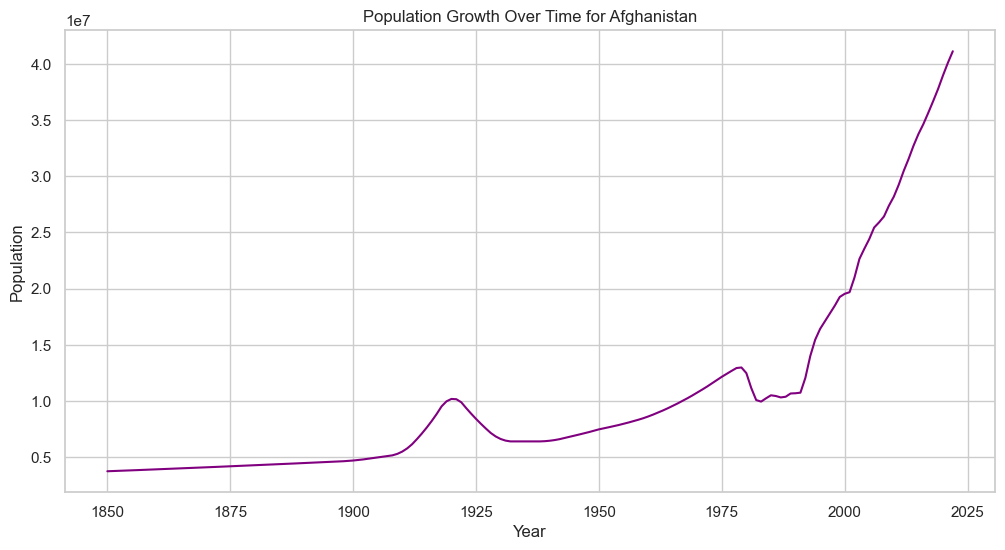

In [16]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=df[df['Country'] == "Afghanistan"], x='Year', y='Population', color="purple")
plt.title("Population Growth Over Time for Afghanistan")
plt.xlabel("Year")
plt.ylabel("Population")
plt.show()


4. Relationship CO₂ Emissions vs. Population (Scatter Plot)

c:\Users\tranh\anaconda3\envs\adsc3910-project-group-5\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


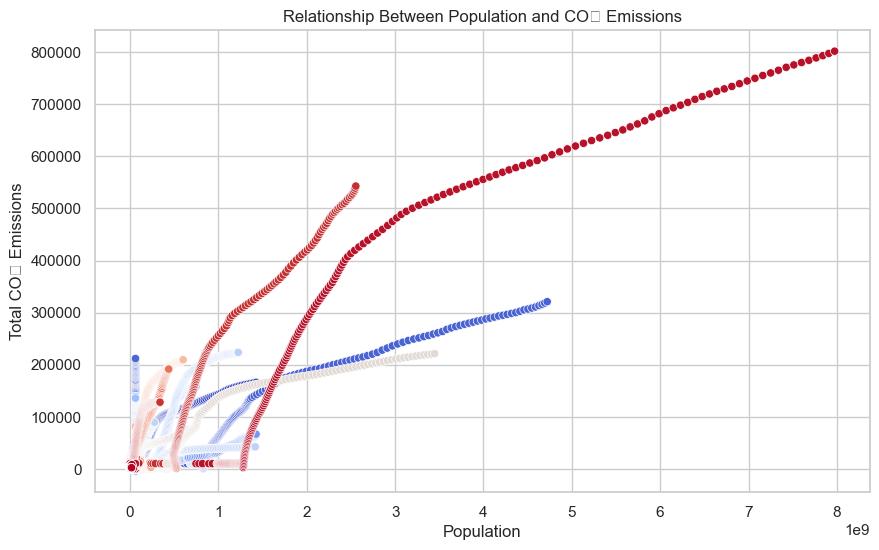

In [17]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Population', y='CO2', hue='Country', palette="coolwarm", legend=None)
plt.title("Relationship Between Population and CO₂ Emissions")
plt.xlabel("Population")
plt.ylabel("Total CO₂ Emissions")
plt.show()


5. Correclation Heatmap between Population C02 and C02 per capita

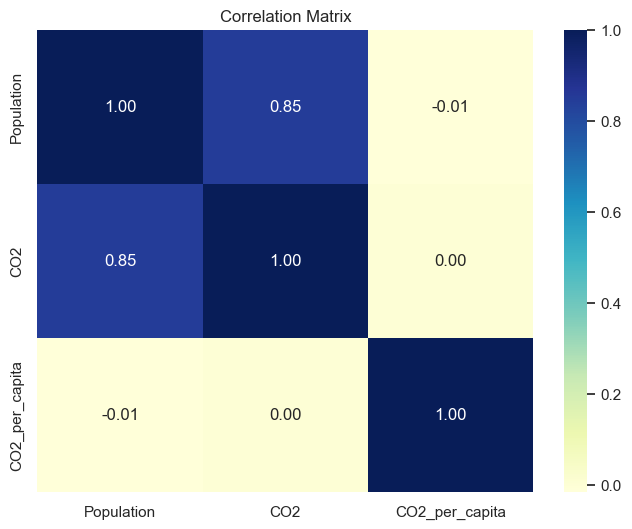

In [18]:
plt.figure(figsize=(8, 6))
correlation_matrix = df[['Population', 'CO2', 'CO2_per_capita']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()


6. CO₂ Emissions Over Time for Different Countries

c:\Users\tranh\anaconda3\envs\adsc3910-project-group-5\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


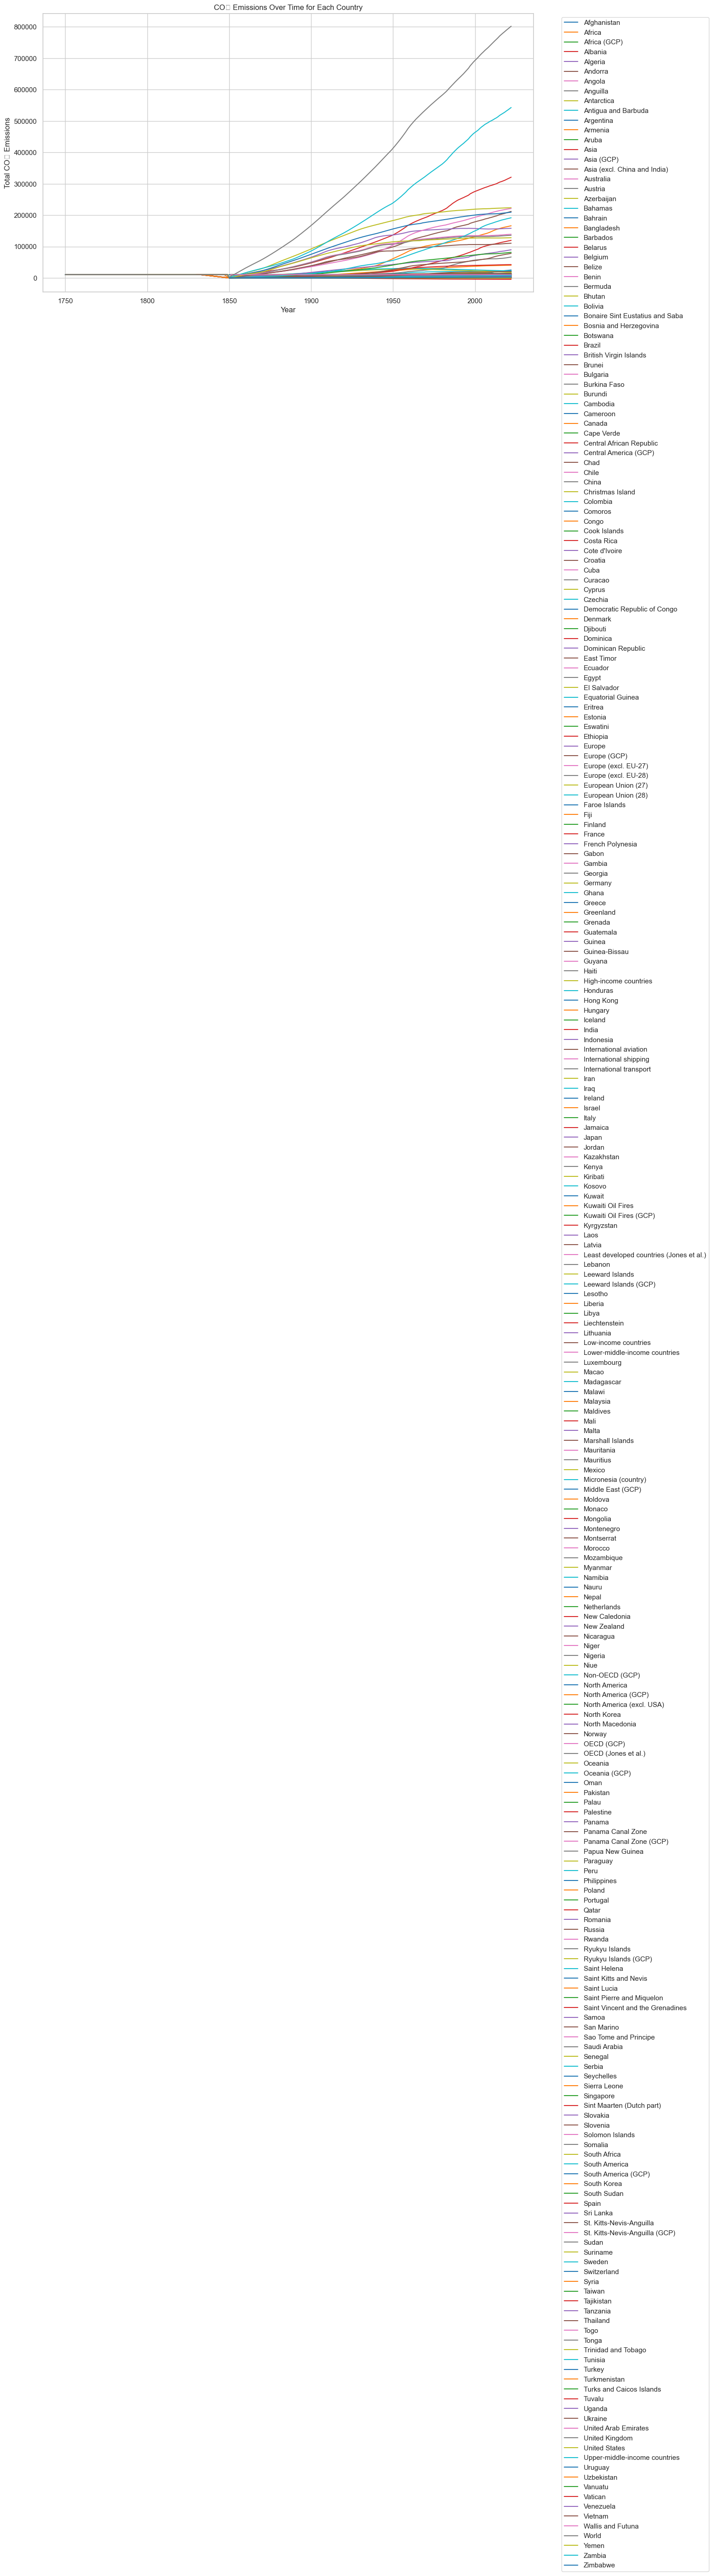

In [19]:
plt.figure(figsize=(14, 8))
sns.lineplot(data=df, x='Year', y='CO2', hue='Country', legend='full', palette='tab10')
plt.title("CO₂ Emissions Over Time for Each Country")
plt.xlabel("Year")
plt.ylabel("Total CO₂ Emissions")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


7. CO2 Emissions Per Capita Over Time for Top 5 Countries

In [30]:
# Filter out non-country entries based on a known list (adjust as needed)
non_countries = ["World", "High-income countries", "Low-income countries", "Upper-middle-income countries", 
                 "Lower-middle-income countries", "Africa", "Europe", "Asia", "Oceania", "Americas", "North America",
                 "South America", "Asia (excl. China and India)", "Europe (excl. EU-27)",
                  "Europe (excl. EU-28)", "North America (excl. USA)" ]

# Filter out non-country rows
df_filtered = df[~df['Country'].isin(non_countries)]


In [31]:
# Get the top 5 countries by average CO₂ emissions from the filtered data
top_countries = df_filtered.groupby('Country')['CO2'].mean().nlargest(5).index
print("Top 5 countries by average CO₂ emissions:", top_countries)


Top 5 countries by average CO₂ emissions: Index(['United States', 'Russia', 'Indonesia', 'Brazil', 'China'], dtype='object', name='Country')


c:\Users\tranh\anaconda3\envs\adsc3910-project-group-5\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


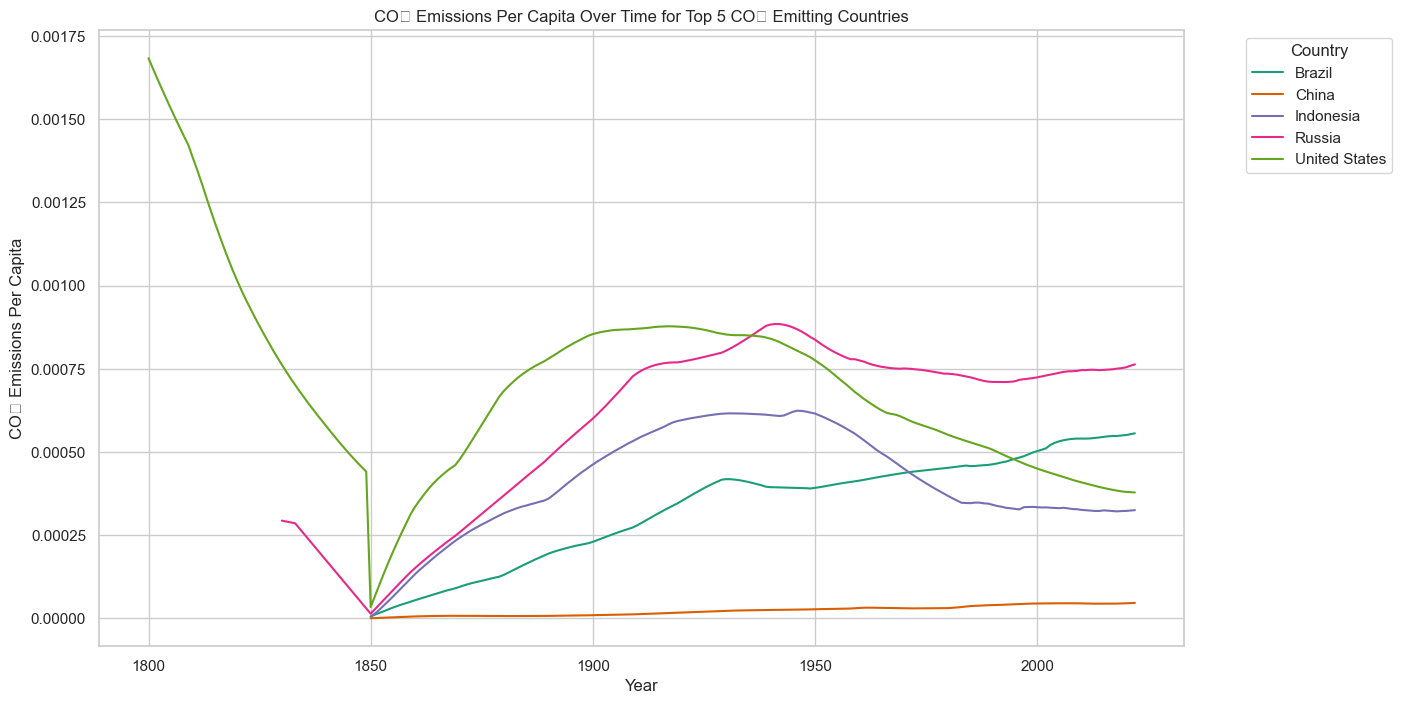

In [32]:
plt.figure(figsize=(14, 8))
sns.lineplot(data=df_filtered[df_filtered['Country'].isin(top_countries)], x='Year', y='CO2_per_capita', hue='Country', palette='Dark2')
plt.title("CO₂ Emissions Per Capita Over Time for Top 5 CO₂ Emitting Countries")
plt.xlabel("Year")
plt.ylabel("CO₂ Emissions Per Capita")
plt.legend(title="Country", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


8. Heatmap of CO2 Emissions Over Time for selected countries

In [35]:
# Define the list of selected countries
selected_countries = ["Afghanistan", "Brazil", "China", "India", "United States"]

# Filter the data for these countries
df_selected = df[df['Country'].isin(selected_countries)]


In [37]:
# Pivot the data for heatmap (Year as columns, Country as rows, CO2 as values)
heatmap_data = df_selected.pivot_table(index='Country', columns='Year', values='CO2', aggfunc='mean').fillna(0)


c:\Users\tranh\anaconda3\envs\adsc3910-project-group-5\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  fig.canvas.draw()
c:\Users\tranh\anaconda3\envs\adsc3910-project-group-5\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


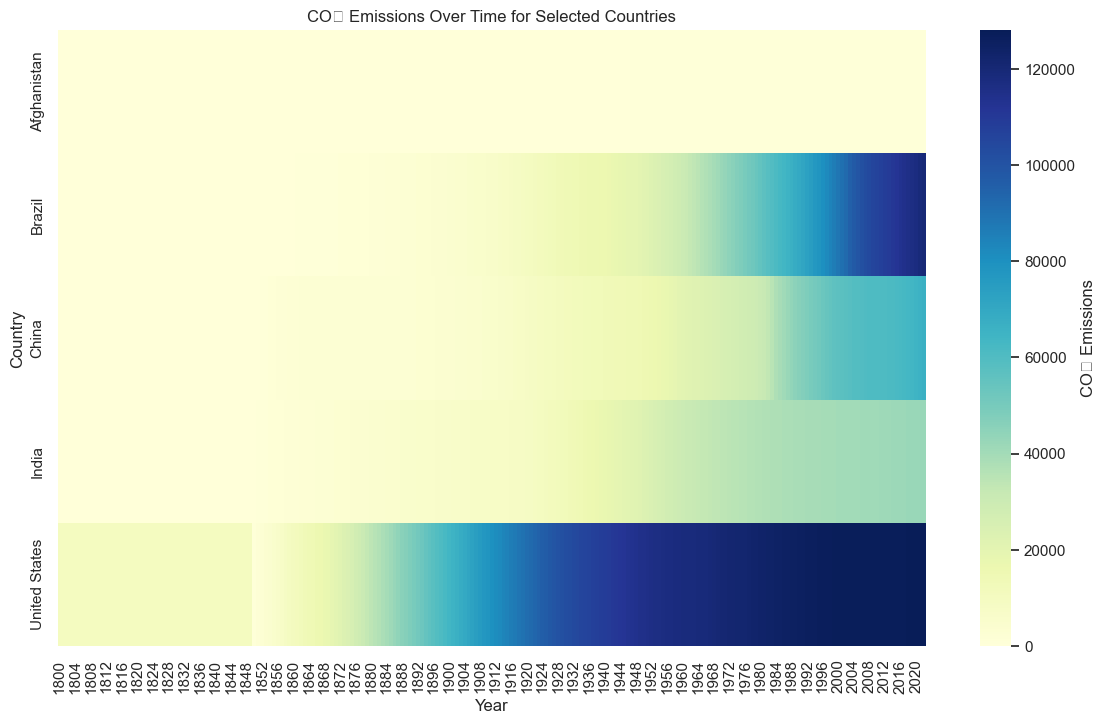

In [38]:
plt.figure(figsize=(14, 8))
sns.heatmap(heatmap_data, cmap='YlGnBu', cbar_kws={'label': 'CO₂ Emissions'}, fmt=".1f")
plt.title("CO₂ Emissions Over Time for Selected Countries")
plt.xlabel("Year")
plt.ylabel("Country")
plt.show()


9.  Boxplot of CO2 Emissions Per Capita by Country for selected countries

In [40]:
# Define the list of selected countries
selected_countries = ["Afghanistan", "Brazil", "China", "India", "United States"]

# Filter the data for these selected countries
df_selected = df[df['Country'].isin(selected_countries)]


C:\Users\tranh\AppData\Local\Temp\ipykernel_36496\513981399.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_selected, x='Country', y='CO2_per_capita', palette="Set3")
c:\Users\tranh\anaconda3\envs\adsc3910-project-group-5\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


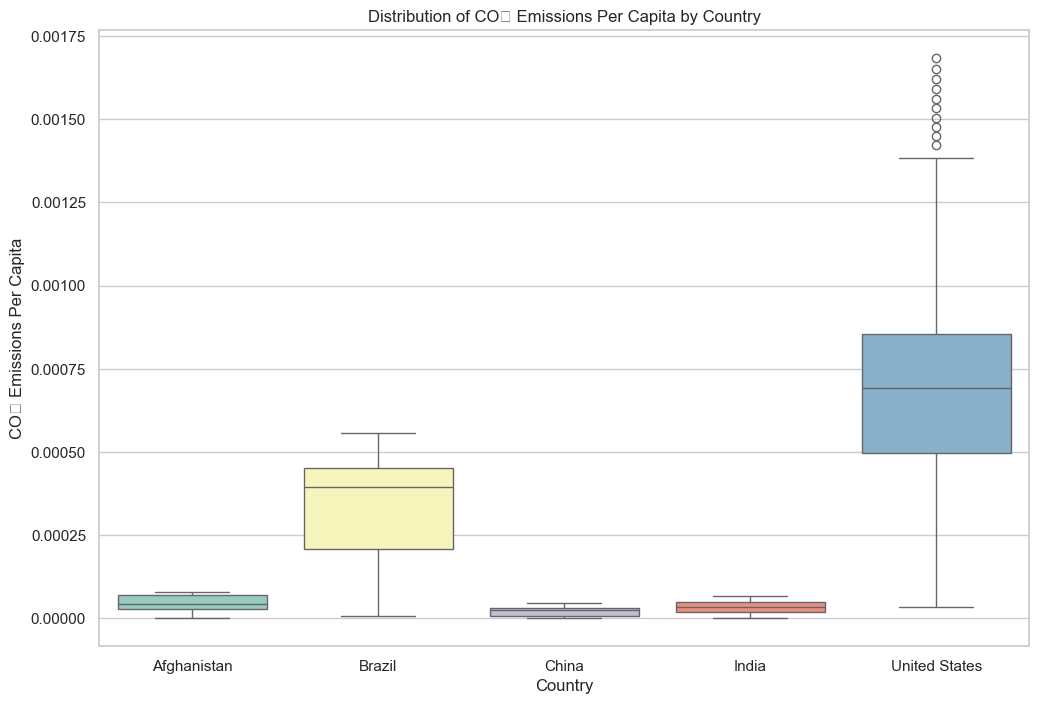

In [41]:
plt.figure(figsize=(12, 8))
sns.boxplot(data=df_selected, x='Country', y='CO2_per_capita', palette="Set3")
plt.title("Distribution of CO₂ Emissions Per Capita by Country")
plt.xlabel("Country")
plt.ylabel("CO₂ Emissions Per Capita")
plt.show()
